# Логистическая регрессия

В этой главе нам предстоит рассмотреть метод логистической регрессии для решения задачи бинарной классификации. Для примера рассмотрим набор данных об соотношении роста и веса для мужчин и женщин [Davis](https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/car/Davis.csv).

In [15]:
import pandas as pd

davis = pd.read_csv('../datasets/Davis.csv', index_col=0)
davis.head()

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0


В этом наборе данных присутсвуют 5 столбцов
  * **sex** - пол
  * **weight** - измеренный вес в кг
  * **height** - измеренный рост в cm
  * **repwt** - вес, который сообщил человек в кг
  * **repht** - рост, который сообщил человек в cm

На примере этого набора данных поставим следующую задачу классификации: *на основе информации об измеренных весе и росте определить пол человека.*

В такой постановке, в качестве признаков мы будем использовать столбцы **weight** и **height**, а в качестве целевой переменной - **sex**.

## Исследование данных

На первом шаге решения поставленой задачи проведем исследование данных путем их визуализации.

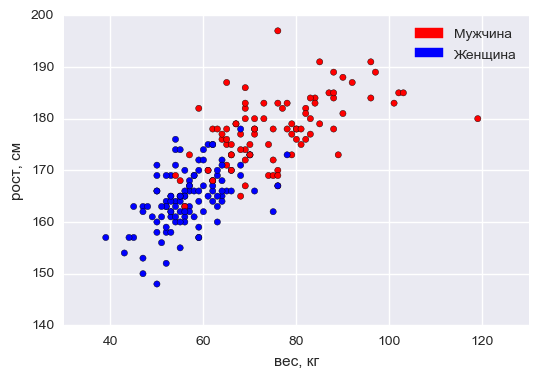

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches

colors = davis['sex'].map({'M': 'r', 'F': 'b'})
plt.scatter(x=davis['weight'], y=davis['height'], c=colors)
red_patch = mpatches.Patch(color='red', label='Мужчина')
blue_patch = mpatches.Patch(color='blue', label='Женщина')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('вес, кг')
plt.ylabel('рост, см')

На графике хорошо видно, что имеется два распределения, которые слегка пересекаются. 

Для решения задачи классификации нам необходимо построить решающее правило. В данном случае его можно представить в виде прямой на плоскости (вес, рост), которая "наилучшим" способом разделит распределения. После чего все точки по одной стороне от прямой можно считать принадлежащими классу "мужчин", а по другую сторону - классу "женщин".

При этом возникают следующие вопросы:
    * как вычислить коэффициенты этой прямой?
    * что означает "наилучшим" способом разделит?

Попробуем нарисовать несколько таких прямых.
  

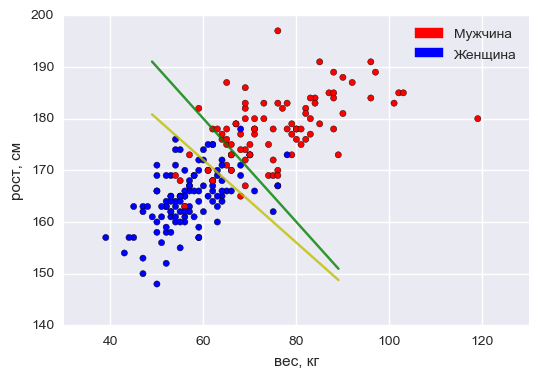

In [37]:
import numpy as np

plt.scatter(x=davis['weight'], y=davis['height'], c=colors)
red_patch = mpatches.Patch(color='red', label='Мужчина')
blue_patch = mpatches.Patch(color='blue', label='Женщина')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('вес, кг')
plt.ylabel('рост, см')

lines = [([240, -1], 'g'),
         ([220, -0.8], 'y')]

for line in lines:
    x = np.linspace(davis['weight'].quantile(0.05), davis['weight'].quantile(0.95), 100)
    y = line[0][0] + x*line[0][1]
    plt.plot(x, y, color=line[1], alpha=0.8)

Из графика видно, что какую-бы прямую мы не выбрали всегда будут точки из обучающей выборки, на которых классификатор будет давать неверный результат. Вычислить для преведенных выше двух прямых такую характеристику как точность (accuracy), которая предсатвляет собой нормированное на единицу число правильных решений классификатора.

In [55]:
from sklearn.metrics import accuracy_score

acc = []
for line in lines:
    pred = davis['height'] - line[0][1]*davis['weight'] - line[0][0] > 0
    pred = pred.map(lambda pred: 'M' if pred else 'F')
    acc.append(accuracy_score(davis['sex'], pred))

In [58]:
print("Точность для зеленой прямой: {}".format(acc[0]))
print("Точность для желтой прямой: {}".format(acc[1]))

Точность для зеленой прямой: 0.905
Точность для желтой прямой: 0.885


Сравнивая результаты мы видим, что точность для зеленой прямой выше, а следовательсно, с точки зрения данного критерия, это решаюшее правило "лучше" желтой прямой.

Подобные рассуждения приводят нас к следующей формальной постановке задачи: следует поставить задачу оптимизации, где в качестве варьируемых параметров будут параметры разделяющей прямой, а в качестве минимизируемой функции - функция обратная к точности.

Попробуем записать это в формальной нотации и сразу для $n$-мерного случая.

Пусть $\theta = (\theta_0, \theta_1, \dots, \theta_n)$ - коэффициенты канонического представления гиперплоскости (для двумерного случая - это будет прямая).

$x = (1, x_1, x_2, \dots, x_n)$ - расширенный вектор признаков (с дополнительной единицей).

Обозначим наши классы числами $-1$ и $1$. Тогда решающее правило $h$ можно записать в виде

$$
h_{\theta}(x) = sign(\theta^Tx).
$$

Определим такую величину как отступ (margin) с помощью выражения
$$
M_{\theta}(x, y) = y\theta^Tx.
$$

**TODO**: вставить картинку с величиной отступа.

Положительное значение отступа означает правильный ответ классификатора, а отрицаиельное - ошибку. Абсолютную величину M можно трактовать как "степень уверенности" классификатора в своем решении.

В качестве функции потерь рассмотрим zero-one loss, которая штрафует классификатор на каждое неправильное решение

$$
L(\theta) = \sum\limits_{i=1}^{n}[M_\theta(x^{(i)}, y^{(i)}) < 0].
$$

Здесь с помощью квадратный скобок обозначается функция индикатора, которая равна единице, если логическое выражение в скобках - истинно и нулю, если ложно.